###### Università degli Studi di Milano, Data Science and Economics Master Degree

# VFA
## Value Function Approximation

### Alfio Ferrara

## Introduction
Reinforcement Learning methods are based on the idea of updating the value $V(s)$ of the states in which the agent can find itself or, alternatively, the value $Q(s, a)$, which represents the value assigned to taking an action $a$ when in state $s$.

In **tabular solutions**, the functions $V(s)$ and $Q(s, a)$ are explicitly represented as tables that associate a value with states and state-action pairs.

However, maintaining $V(s)$ and $Q(s, a)$ explicitly is **not practical** when the number of states becomes significantly large, even if finite. Some examples:

- The possible configurations of the **Rubik’s Cube** are approximately $4.3 \times 10^{19}$.  
- The number of possible **positions in Chess** is around $10^{47}$.  
- In a **real-world map**, even if represented as a discrete grid, there can be **billions of different positions**.

Moreover, there are several real world situations where the number of states is simply **infinite**, for example because we have a continuous state space. Examples:
- In **autonomous vehicle control** the veihicle state is typically represented by continuous variables, such as **speed**, **position** as $(x, y)$ coordinates, **steering angle**, etc.
- If we need to **control the temperature** in a room, we typically describe the state as a combination of **temperature**, **humidity**, **number of people in the room**, etc.
- In a **real-world map**, instead of a large grid, we may want to represent the position of agents just through their coordinates **(longitude, latitude)**.

### A matter of generalization
However, the number of states is not the only limitation of tabular solutions. There is also another relevant issue that is associated with the information that the agent can exploit about a state. Let's see a couple of examples:

![](./imgs/obs-space.png)



- **First example**: here we have a discrete state space. However, with respect to the target of reaching the apple, the situation of the pig (the agent) is identical. Thus, we expect $V(s_A) \sim V(s_B)$, but the two states are distinct in a tabular setting. This means that when the Agent reaches $s_B$ it cannot exploit what has been learned about $V(s_A)$ in order to estimate $V(s_B)$.
- **Second example**: the position of the space probe (the agent) is almost the same in $s_A$ and $s_B$. Thus, we would like to exploit the information available about $V(s_A)$ in order to choose the action to take when in $s_B$.

To overcome this issue, we would like to have a mechanism for **generalizing the notion of state** and act similarly when we are in states that are almost identical.

## Jousting Duel: A Tactical Medieval Jousting Game
As an example of such an environment, we introduce Jousting Duel. Jousting Duel is a reinforcement learning-driven medieval jousting game where **two knights charge toward each other in a high-speed duel**. The player controls one knight, making **strategic decisions** on **steering**, **speed**, and **lance positioning** to **maximize their chances of landing a successful hit** while avoiding their opponent’s attack.

The game features a continuous state space, where the knight’s position, speed, and lance angle are dynamically updated. However, the player can only take discrete actions, such as steering left or right and adjusting their lance angle. Success depends on precise timing and positioning, requiring the agent to learn optimal strategies through reinforcement learning.

The goal is to hit the opponent's weak spot while dodging their lance. The game rewards efficient jousting techniques and penalizes missed attacks or poor positioning. 

<img style="width: 50%;" src="./imgs/jousting-duel.png" />

### Tech notes
#### Opponent (aka Environment) parameters
- `max_distance = 10.0` : starting distance between opponents
- `min_distance = 0.0` : collision point
- `speed_agent = speed_opponent = 1.0` : fixed speed for agent and opponent
- `lance_angle_change = 0.1` : Change in lance angle per action
- `opponent_lance_angle = np.random.uniform(-1, 1)` : random lance angle per episode

#### State space
- $\delta_t$: **relative distance** of opponents at time $t$ in $[\textrm{max distance}, 0]$
- $\sigma$: **relative speed** of the two opponents in $[-5, 5]$
- $\theta$: **agent lance angle** in $[-1, 1]$
- $\phi$: **opponent lance angle** in $[-1, 1]$

#### Action space
With $c$ as a constant steer rate:
- $a=0$: **steer left** $\rightarrow \theta = \theta - c$
- $a=1$: **stay centered** $\rightarrow \theta = \theta$
- $a=2$: **steer right** $\rightarrow \theta = \theta + c$
- $a=3$: **lance up** $\rightarrow \theta = \theta + c$
- $a=4$: **lance down** $\rightarrow \theta = \theta - c$
- $a=5$: **increase speed** $\rightarrow \sigma = \min{(\sigma + 1; 5)}$

#### Reward
- if `relative_distance <= min_distance`
    - if $\mid \theta - \phi \mid \leq 0.2$
        - $r = 100$
    - else
        - $r = -50$
- else
    - $r = -1$

**note** that we have a negative reward when the two opponents are not in contact. This should incentivate the agent in increasing speed.

For the implementation as a `gym` environment, see [JoustingDuelEnv](./gymbase/environments.py)

In [1]:
from gymbase import environments
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time


In [2]:
env = gym.make('JoustingDuel-v0', distance=10)
state, _ = env.reset()
action_labels = {
    0: 'steer left', 1: 'stay centered', 2: 'steer right', 3: 'lance up', 4: 'lance down', 5: 'increse speed'
}

done = False
while not done:
    action = env.action_space.sample()
    print(f"\nAction taken: {action_labels[action]}")
    state, reward, done, truncated, info = env.step(action)
    env.render()
env.close()


Action taken: steer left

        Distance: 8.00, 
        Agent Lance Angle: -0.10, 
        Opponent Lance Angle: -0.09, 
        Distance to target: 0.01

Action taken: increse speed

        Distance: 5.00, 
        Agent Lance Angle: -0.10, 
        Opponent Lance Angle: -0.09, 
        Distance to target: 0.01

Action taken: lance down

        Distance: 2.00, 
        Agent Lance Angle: -0.20, 
        Opponent Lance Angle: -0.09, 
        Distance to target: 0.11

Action taken: lance down

        Distance: -1.00, 
        Agent Lance Angle: -0.30, 
        Opponent Lance Angle: -0.09, 
        Distance to target: 0.21


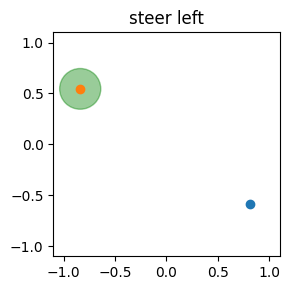

In [4]:
state, _ = env.reset()
done = False
while not done:
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)
    clear_output(wait=True)
    im = env.unwrapped.show_target(title=action_labels[action])
    time.sleep(1)
env.close()

## VFA
Now that we do not have discrete states anymore, in order to estimate the **value of a state** $V(s)$, we need to redefine the value function in order to approximate it.

$$
V(s, \mathbf{w}) \rightarrow \mathbb{R}
$$

where $\mathbf{w}$ is a vector of parameters.

The same can be said for the state-action value $Q(s, a)$

$$
Q(s, a, \mathbf{w}) \rightarrow \mathbb{R}
$$

Function approximators can include **neural networks**, **polynomials**, or **radial basis functions**

### Polynomial solutions
An example of a polynomial solution for state value approximation may be something like

$$
V(s, \mathbf{w}) \approx w_0 + w_1 s + w_2 s^2
$$

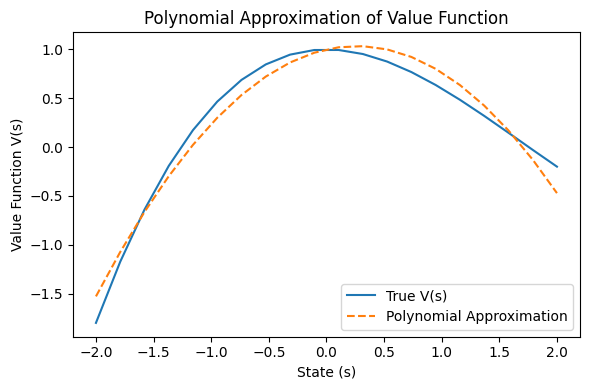

In [9]:
from numpy.polynomial.polynomial import Polynomial
import numpy as np

s_values = np.linspace(-2, 2, 20)
true_V = 1 - 0.5 * s_values**2 + 0.1 * s_values**3

# Fit a polynomial of degree 2
coeffs = np.polyfit(s_values, true_V, 2)
V_approx = np.polyval(coeffs, s_values)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(s_values, true_V, label="True V(s)", linestyle="solid")
ax.plot(s_values, V_approx, label="Polynomial Approximation", linestyle="dashed")
ax.set_xlabel("State (s)")
ax.set_ylabel("Value Function V(s)")
ax.legend()
ax.set_title("Polynomial Approximation of Value Function")
plt.tight_layout()
plt.show()

For the $Q(s, a)$ function, we can find a more general solution in order to approximate the value depending both on the state and the action, like:

$$
Q(s, a, \mathbf{w}) = w_0 + w_1 s + w_2 a + w_3 s^2 + w_4 a^2 + w_5 sa
$$

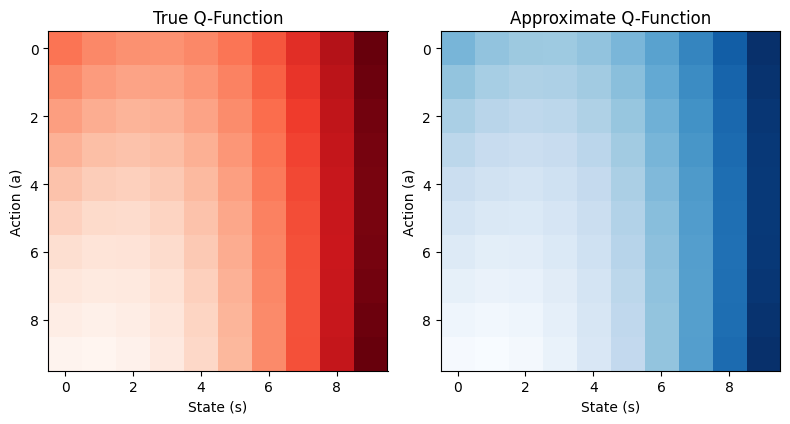

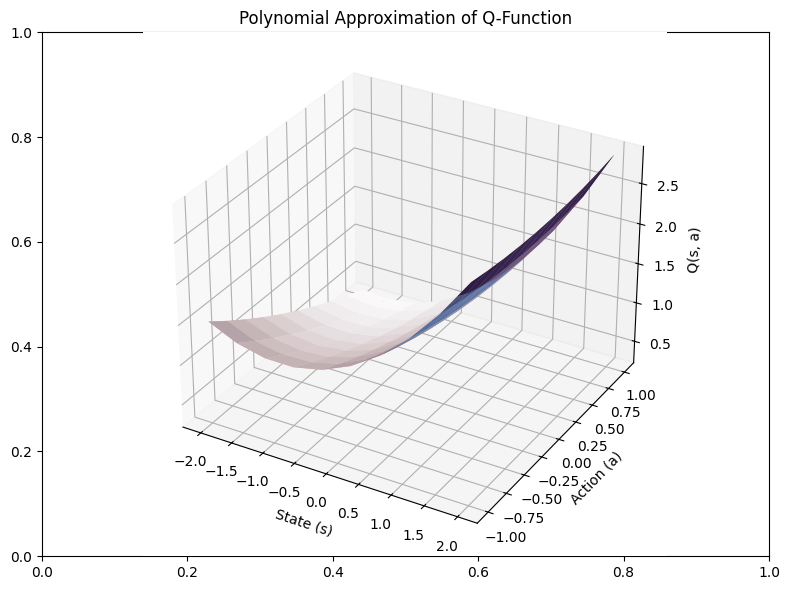

In [34]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

s_values = np.linspace(-2, 2, 10)
a_values = np.linspace(-1, 1, 10)

S, A = np.meshgrid(s_values, a_values)
S_flat, A_flat = S.flatten(), A.flatten()

true_Q = 1 + 0.5 * S_flat - 0.3 * A_flat + 0.2 * S_flat**2 + 0.1 * A_flat**2 + 0.15 * S_flat * A_flat

poly = PolynomialFeatures(degree=2, include_bias=True)
X_poly = poly.fit_transform(np.column_stack((S_flat, A_flat)))

model = LinearRegression()
model.fit(X_poly, true_Q)

Q_approx = model.predict(X_poly)

Q_approx_grid = Q_approx.reshape(S.shape)
Q_true_grid = true_Q.reshape(S.shape)

fig, ax = plt.subplots(figsize=(8, 6), ncols=2)
ax[0].set_title("True Q-Function")
ax[0].imshow(Q_true_grid, cmap='Reds')
ax[0].set_xlabel("State (s)")
ax[0].set_ylabel("Action (a)")
ax[1].set_title("Approximate Q-Function")
ax[1].imshow(Q_true_grid, cmap='Blues')
ax[1].set_xlabel("State (s)")
ax[1].set_ylabel("Action (a)")
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S, A, Q_true_grid, cmap='Reds', alpha=1)
ax.plot_surface(S, A, Q_approx_grid, cmap='Blues', alpha=0.6)
ax.set_xlabel("State (s)")
ax.set_ylabel("Action (a)")
ax.set_zlabel("Q(s, a)")
ax.set_title("Polynomial Approximation of Q-Function")
plt.tight_layout()
plt.show()




### Radial solutions

A radial function is a function whose value depends only on the distance from a given center point. The idea is to estimate some **central points** by interacting with the environment and then estimate the value of each state by some radial function. For example:

$$
V(s, \mathbf{w}) = \sum\limits_{i} w_i \phi_i(s)
$$

where

$$
\phi(s) = \exp \left( - \frac{\parallel s - c \parallel ^{2}}{2\sigma^2} \right)
$$

The same can be done for $Q(s, a)$

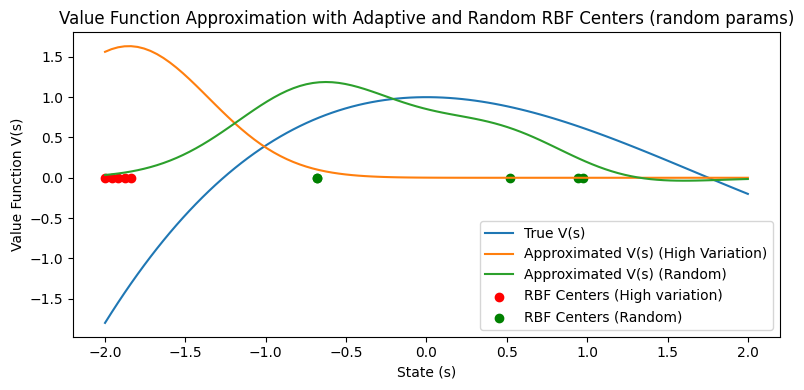

In [46]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

s_values = np.linspace(-2, 2, 100).reshape(-1, 1)

V_true = 1 - 0.5 * s_values**2 + 0.1 * s_values**3 

num_centers = 5
# Compute absolute differences to find regions of high variation
value_differences = np.abs(np.gradient(V_true.flatten()))

# Select the states with highest variation as RBF centers
center_indices = np.argsort(value_differences)[-num_centers:]
centers = s_values[center_indices]

random_centers = np.random.choice(V_true.flatten(), size=num_centers).reshape(-1, 1)

# Radial approximation
sigma = 0.5
rbf_features = np.exp(-cdist(s_values, centers)**2 / (2 * sigma**2))

rbf_features_random = np.exp(-cdist(s_values, random_centers)**2 / (2 * sigma**2))

weights = np.random.uniform(-1, 1, num_centers)

V_approx = rbf_features @ weights
V_approx_random = rbf_features_random @ weights


fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(s_values, V_true, label="True V(s)")
ax.plot(s_values, V_approx, label="Approximated V(s) (High Variation)")
ax.plot(s_values, V_approx_random, label="Approximated V(s) (Random)")
ax.scatter(centers, np.zeros_like(centers), color='red', marker='o', label="RBF Centers (High variation)")
ax.scatter(random_centers, np.zeros_like(random_centers), color='green', marker='o', label="RBF Centers (Random)")
ax.set_xlabel("State (s)")
ax.set_ylabel("Value Function V(s)")
ax.set_title("Value Function Approximation with Adaptive and Random RBF Centers (random params)")
ax.legend()
plt.tight_layout()
plt.show()

#### Some notes about polynomial and radial solutions

In both this kind of solutions, we need to estimate the value of the parameters $\mathbf{w}$. **Learning in the VFA environment is no more a matter of directly estimate $V(s)$ or $Q(s, a)$, but rather to model those functions somehow**, and then **estimate their parameters**.

To this end, we will see that **differentiable functions** are to be preferred for modeling $V(s)$ and $Q(s, a)$ because they provide a gradient that can be used for updates. For the time being, let's just see some drawbacks of polynomial and radial solutions.

##### Polynomials
- As the number of state variables increases, the number of polynomial terms explodes causing a course of dimensionality, because we need to many parameters
- When the value function is highly non linear, with strong discontinuities, polynomial solutions struggle to adapt the estimation to the real function
- Polynomials may cause numerical instability for higher degrees functions

##### Radial
- Choosing good centers is challenging
- The number of centers mey become high to have good estimations and this implies an increasing number of calculations
- The parameter $\sigma$ has a huge impact on the solution quality and it is hard to estimate

## Linear Value Function Approximation
In order to simplify the VFA problem, an easy and scalable solution is to approximate the value state function as a linear combination of features and parameters, such as:
$$
V(s, \mathbf{w}) = \sum\limits_{i}^{n} w_i s_i
$$

Note that here $s_i$ represents a **feature** of the state. While the combination of **features** and **parameters** is **linear**, features do not need to be linear as well. They can be transformed in several different ways. So, the general form is:

$$
V(s, \mathbf{w}) = \sum\limits_{i}^{n} w_i f(s_i)
$$

where $f(s_i)$ is a function that transforms the state features. This can be:
- a polynomial, like $f(s_i) = s_{i}^{2}$
- a radial function, like $f(s_1) = \epsilon^{\frac{-(s_1 - c_)^2}{2\sigma^{2}}}$
- a Fourier-like transformation, like $f(s_i) = \cos(\pi s_i)$

For $Q(s, a)$, we use a function that combines state and action, such as state features and one-hot encoding of actions
$$
Q(s, a, \mathbf{w}) = \sum\limits_{i}^{n} w_i f(s_i, a)
$$

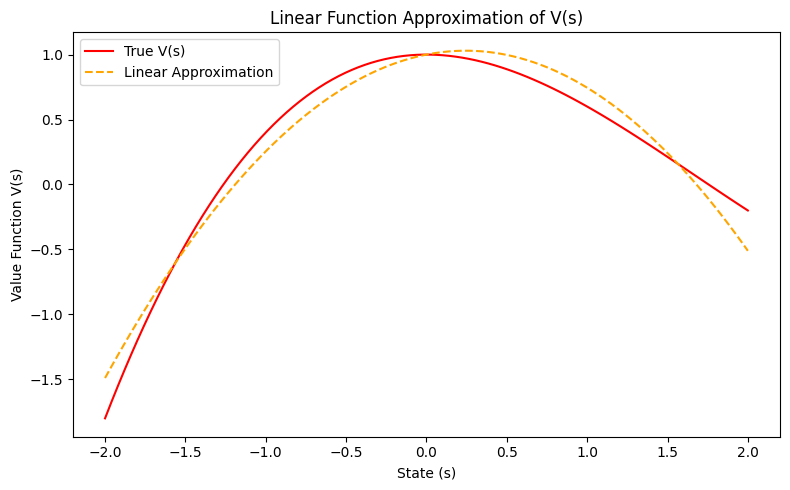

In [54]:
from sklearn.linear_model import LinearRegression

s_values = np.linspace(-2, 2, 100).reshape(-1, 1)

true_V = 1 - 0.5 * s_values**2 + 0.1 * s_values**3  # Example nonlinear value function

# Polynomial features
phi_features = np.column_stack([s_values**i for i in range(3)])

model = LinearRegression()
model.fit(phi_features, true_V)

V_approx = model.predict(phi_features)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(s_values, true_V, label="True V(s)", linestyle="solid", color="red")
ax.plot(s_values, V_approx, label="Linear Approximation", linestyle="dashed", color="orange")

ax.set_xlabel("State (s)")
ax.set_ylabel("Value Function V(s)")
ax.set_title("Linear Function Approximation of V(s)")
ax.legend()
plt.tight_layout()
plt.show()